In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Define the path to your zip file
zip_path = '/content/drive/My Drive/Datasets/datasets.zip'

# Define the extraction path
extract_to = '/content/datasets'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

os.makedirs('content/model', exist_ok=True)
os.makedirs('content/util', exist_ok=True)
os.makedirs('content/cache', exist_ok=True)

# Unzip the file
!unzip -q "$zip_path" -d "$extract_to"


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from datetime import datetime
import os
import random
import time

from util import vcpi_util

----
# Global Variables


In [ ]:
HEIGHT = 32
WIDTH = 32
NUM_CHANNELS = 3
BATCH_SIZE = 64
LATENT_SPACE_DIM = 2

MODEL_PATH = 'model'

train_online = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Sample and Explore

We will be using the dataset provided of the GTSRB (German Traffic Sign Recognition Benchmark) to train a model to recognize traffic signs. The dataset consists of 43 classes of traffic signs and is already split into training and testing sets.

-  We defined the standard size of the images to be 32 by 32 which is the size of the smaller images in the dataset and since we have very low computational power we decided to keep the size of the images small.

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize([32, 32]), # Resize images to 32x32
    transforms.ToTensor() # Convert images to torch Tensors and rescale pixels to [0, 1]
])

# Import datasets from the directory
train_dataset = datasets.ImageFolder(root='datasets/train_images', transform=transform)
test_dataset = datasets.ImageFolder(root='datasets/test_images', transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Length of the train and test datasets
print(f'Training set size: {len(train_dataset)}')
print(f'Test set size: {len(test_dataset)}')

# Check the number of classes in the train and test datasets
print(f'Number of classes in training set: {len(train_dataset.classes)}')
print(f'Number of classes in test set: {len(test_dataset.classes)}')

# Verify class distribution
# print(f'Class distribution in training set: {train_dataset.class_to_idx}')
# print(f'Class distribution in test set: {test_dataset.class_to_idx}')

Training set size: 39209
Test set size: 12630
Number of classes in training set: 43
Number of classes in test set: 43


# Pre-computing Labels

In [ ]:
# # Save labels to files to reduce I/O overhead during analysis
train_labels = []
for _, y in train_loader:
    train_labels.extend(y.numpy())

test_labels = []
for _, y in test_loader:
    test_labels.extend(y.numpy())

np.save('cache/train_labels.npy', np.array(train_labels))
np.save('cache/test_labels.npy', np.array(test_labels))

# Visualize some of the images in the dataset

Image shape: torch.Size([64, 3, 32, 32]), label shape: torch.Size([64])
Min and max pixel values: [0.019607843831181526, 1.0]
Number of classes 41


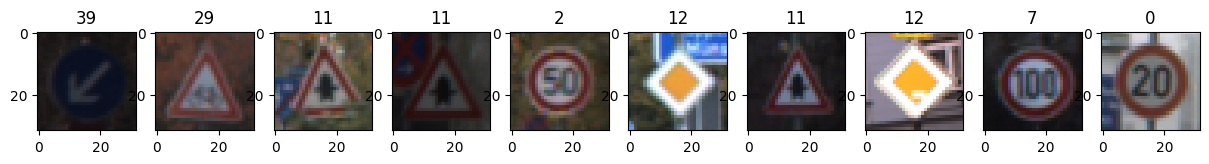

In [ ]:
# Visualize random images from the training set
for x, y in train_loader:

    print(f'Image shape: {x.shape}, label shape: {y.shape}')
    print(f'Min and max pixel values: [{torch.min(x)}, {torch.max(x)}]')
    print(f'Number of classes {torch.max(y)}')

    figure, axis = plt.subplots(1, 10, figsize=(15,15))

    for idx in range(10):
        axis[idx].imshow(x[idx].permute(1, 2, 0))
        axis[idx].set_title(y[idx].numpy())
    break

We verify that the number of classes is 43 and that the number of images in the training and testing sets is 34799 and 12630 respectively.
- Since the number of classes is relatively large, we can try to group the classes into fewer categories to simplify the problem.
- We can also try to use data augmentation to increase the number of images in the training set. This will help the model generalize better and prevent overfitting.
- We can also note that the images have very different brightness and contrast levels. We should try to normalize the images to make the model more robust to these variations.

# Data Preprocessing

In [ ]:
def plot_distrib(data_path: str, title: str):
    # Load data from the .npy file
    data = np.load(data_path)

    # Convert the numpy array to a pandas DataFrame
    df = pd.DataFrame(data, columns=['Labels'])

    # Plot the distribution using Plotly Express
    fig = px.histogram(df, x='Labels', title=title)
    fig.show()

# Plot distribution for train labels
plot_distrib(data_path='cache/train_labels.npy', title="Training samples distribution")

# Plot distribution for test labels
plot_distrib(data_path='cache/test_labels.npy', title="Testing samples distribution")


There is a lot of imbalance between classes, for example, class 0, 19, 32 and others have very few images, close to 60, whilst others like 2 and 38 have close to 750. If this imbalance leads to poor performance, we can try some techniques to improve the data:
- Augmenting the classes with fewer images by rotating, changing colors, cropping to have more data
- Applying class weights to the loss function to penalize the model more when it makes mistakes on the classes with fewer images
- Reduce the number of classes by creating more general categories - This is not what we intend to do as it differs from our goal of recognizing the traffic signs as they are, but it is an option if the model is not performing well

# Data Augmentation and Alteration

### Split data Into Training and Validation Sets

We will divide our training dataset into training and validation sets. We will use 80% of the data for training and 20% for validation.

In [ ]:
train_percentage = 0.8
total_samples = len(train_dataset)

train_size = int(train_percentage * total_samples)
val_size = total_samples - train_size

train_set, val_set = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")

Training set size: 31367
Validation set size: 7842


# 1. First Model without any Data Augmentation

In [ ]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes=43):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu1 = nn.LeakyReLU(0.01)
        self.dropout1 = nn.Dropout2d(0.25)

        self.conv2 = nn.Conv2d(128, 256, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(256)
        self.relu2 = nn.LeakyReLU(0.01)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.25)

        self.conv3 = nn.Conv2d(256, 512, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(512)
        self.relu3 = nn.LeakyReLU(0.01)
        self.maxpool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout2d(0.25)

        self.fc1 = nn.Linear(512*4*4, 128)
        self.relu4 = nn.LeakyReLU(0.01)
        self.dropout4 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)

        x = x.view(-1, 512*4*4)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout4(x)

        x = self.fc2(x)
        return x

# Callbacks

In [ ]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def batch_gd(model, criterion, optimizer, train_loader, test_loader, early_stopping:bool = False, \
    early_stopper:EarlyStopping = None, epochs: int = 10):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, test_losses = np.zeros(epochs), np.zeros(epochs)

    for it in range(epochs):  # iterate over epochs

        # ----- Training -----

        t0 = datetime.now()
        model.train()
        train_loss = []

        for idx, data in tqdm(enumerate(train_loader), total=len(train_loader)):  # iterate over batches
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)  # convert the targets to the new classes
            optimizer.zero_grad() # reset the optimizer gradient between steps

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # backward pass
            loss.backward() # compute the gradient
            optimizer.step() # perform a step of gradient descent

            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)


        # ----- Eval -----

        model.eval()
        test_loss = []

        for idx, data in tqdm(enumerate(test_loader), total=len(test_loader)):  # iterate over batches
            inputs, targets = data  # iterate over batches
            inputs, targets = inputs.to(
                device), targets.to(device)  # convert the targets to the new classes

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        train_losses[it], test_losses[it] = train_loss,  test_loss
        dt = datetime.now() - t0

        if early_stopping:
            if early_stopper.early_stop(test_loss):
                print(f'Stopped at epoch: {it+1} with Train Loss : {train_loss:.4f}, Test Loss : {test_loss:.4f}')
                return train_losses, test_losses

        print(f'Epoch {it+1} / {epochs}: Train Loss : {train_loss:.4f}, Test Loss : {test_loss:.4f}, duration: {dt}')

    # Save the model
    torch.save(model.state_dict(), os.path.join(MODEL_PATH, 'model.pth'))

    return train_losses, test_losses

In [ ]:
# Instantiate the model
model = CNN()
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Create ReduceLROnPlateau scheduler
reduce_lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Print the summary of the model
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           9,728
       BatchNorm2d-2          [-1, 128, 28, 28]             256
         LeakyReLU-3          [-1, 128, 28, 28]               0
         Dropout2d-4          [-1, 128, 28, 28]               0
            Conv2d-5          [-1, 256, 24, 24]         819,456
       BatchNorm2d-6          [-1, 256, 24, 24]             512
         LeakyReLU-7          [-1, 256, 24, 24]               0
         MaxPool2d-8          [-1, 256, 12, 12]               0
         Dropout2d-9          [-1, 256, 12, 12]               0
           Conv2d-10            [-1, 512, 8, 8]       3,277,312
      BatchNorm2d-11            [-1, 512, 8, 8]           1,024
        LeakyReLU-12            [-1, 512, 8, 8]               0
        MaxPool2d-13            [-1, 512, 4, 4]               0
        Dropout2d-14            [-1, 51

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



In [ ]:
train_losses, test_losses = batch_gd(model=model,
                                    criterion=criterion,
                                    optimizer=optimizer,
                                    train_loader=train_loader,
                                    test_loader=test_loader,
                                    early_stopping=False,
                                    early_stopper=None,
                                    epochs=10)

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

Epoch 1 / 10: Train Loss : 1.0795, Test Loss : 0.2607, duration: 0:00:43.086032


  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

Epoch 2 / 10: Train Loss : 0.1687, Test Loss : 0.1742, duration: 0:00:46.218728


  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

Epoch 3 / 10: Train Loss : 0.1089, Test Loss : 0.1480, duration: 0:00:43.508959


  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

Epoch 4 / 10: Train Loss : 0.0825, Test Loss : 0.2128, duration: 0:00:43.044151


  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

Epoch 5 / 10: Train Loss : 0.0695, Test Loss : 0.1852, duration: 0:00:43.784968


  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

Epoch 6 / 10: Train Loss : 0.0619, Test Loss : 0.1682, duration: 0:00:43.428457


  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

Epoch 7 / 10: Train Loss : 0.0468, Test Loss : 0.1797, duration: 0:00:42.845367


  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

Epoch 8 / 10: Train Loss : 0.0493, Test Loss : 0.1914, duration: 0:00:42.627109


  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

Epoch 9 / 10: Train Loss : 0.0454, Test Loss : 0.1806, duration: 0:00:53.652492


  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

Epoch 10 / 10: Train Loss : 0.0523, Test Loss : 0.1363, duration: 0:00:46.348024


In [ ]:
def report(model, loader, train_losses, test_losses):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test_loss')
    plt.legend()
    plt.plot

    p_test, y_test = np.array([]), np.array([])
    X_test = []

    model.eval()

    for idx, data in tqdm(enumerate(loader), total=len(loader)):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        X_test.append(inputs)
        p_test = np.concatenate((p_test, predictions.cpu().numpy()))
        y_test = np.concatenate((y_test, targets.cpu()))

    print(classification_report(y_test, p_test))
    cm = confusion_matrix(y_test, p_test)
    plt.figure(figsize=(15,15))
    sns.heatmap(cm, cmap='Blues', annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('True label')
    plt.show()

    return X_test, p_test, y_test

  0%|          | 0/198 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        60
         1.0       0.96      0.98      0.97       720
         2.0       0.98      0.99      0.99       750
         3.0       0.98      0.94      0.96       450
         4.0       0.98      1.00      0.99       660
         5.0       0.94      0.95      0.95       630
         6.0       1.00      0.89      0.94       150
         7.0       1.00      0.96      0.98       450
         8.0       0.98      0.98      0.98       450
         9.0       0.97      0.99      0.98       480
        10.0       0.99      1.00      0.99       660
        11.0       0.98      0.93      0.95       420
        12.0       0.99      0.99      0.99       690
        13.0       1.00      1.00      1.00       720
        14.0       1.00      1.00      1.00       270
        15.0       1.00      1.00      1.00       210
        16.0       1.00      0.99      1.00       150
        17.0       1.00    

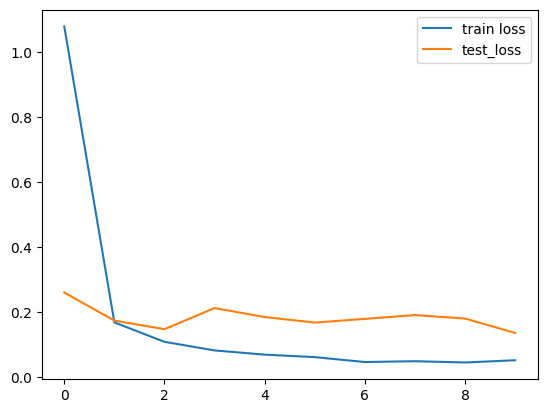

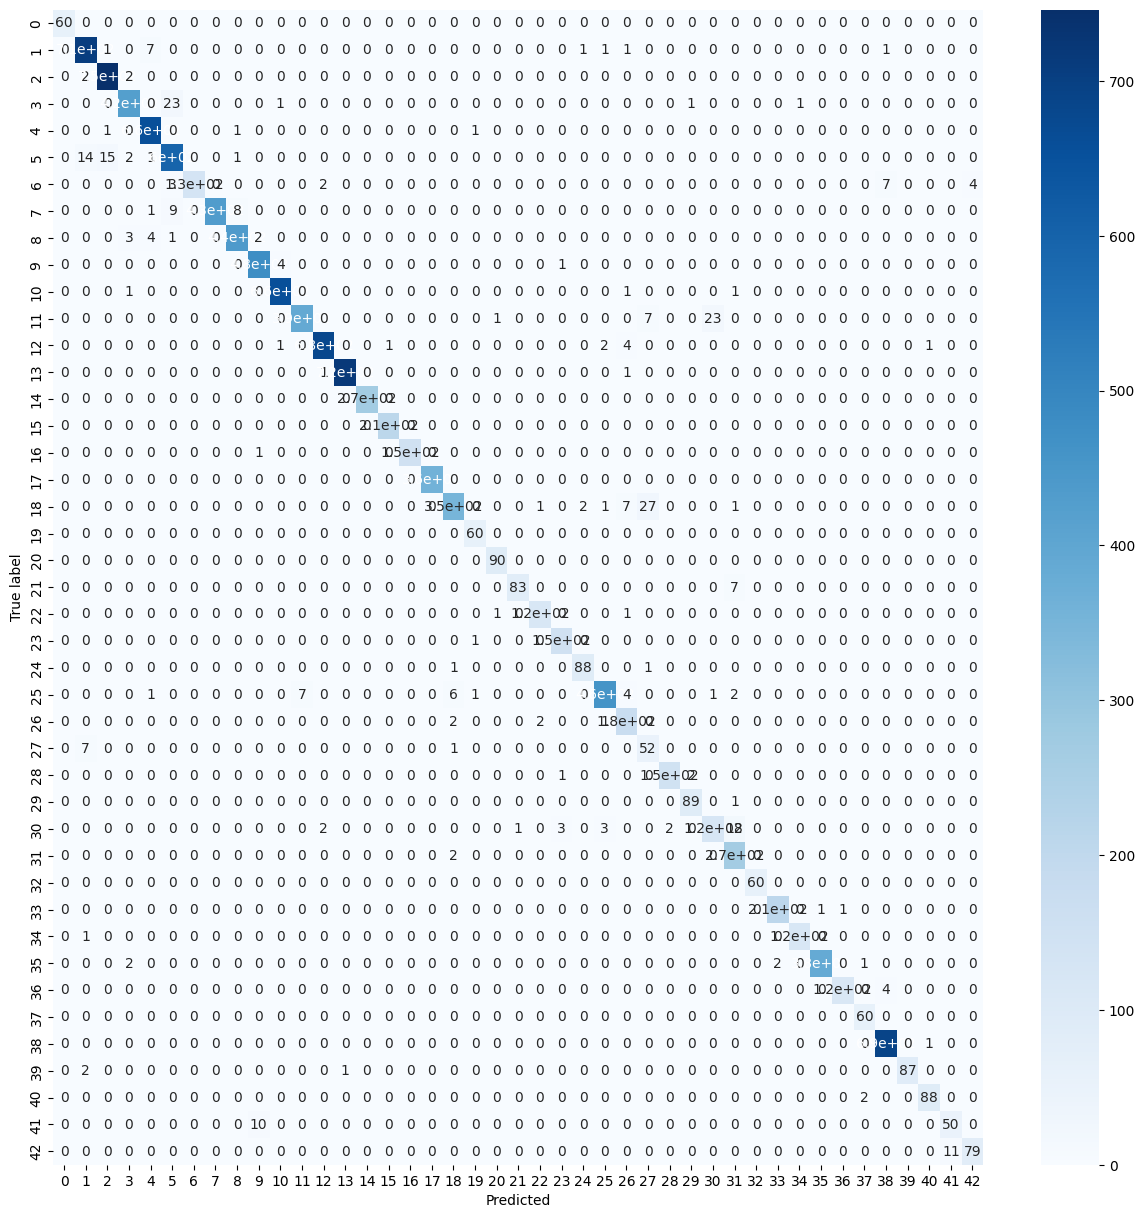

In [ ]:
X_test, p_test, y_test = report(model, test_loader, train_losses, test_losses)

## Results

The model had decent results for being the first model without any data augmentation. The accuracy on the test set was 0.95 but there are some notes to be made:

- Many of the danger signs were missclassified between them, might be due to the extremely poor quality of some of the images, so we might need to preprocess the images more to make them more uniform, adding noise and random marks to the images to make the model more robust to these variations.
- The same can be said for the speed limit signs, being missclassified as other speeds

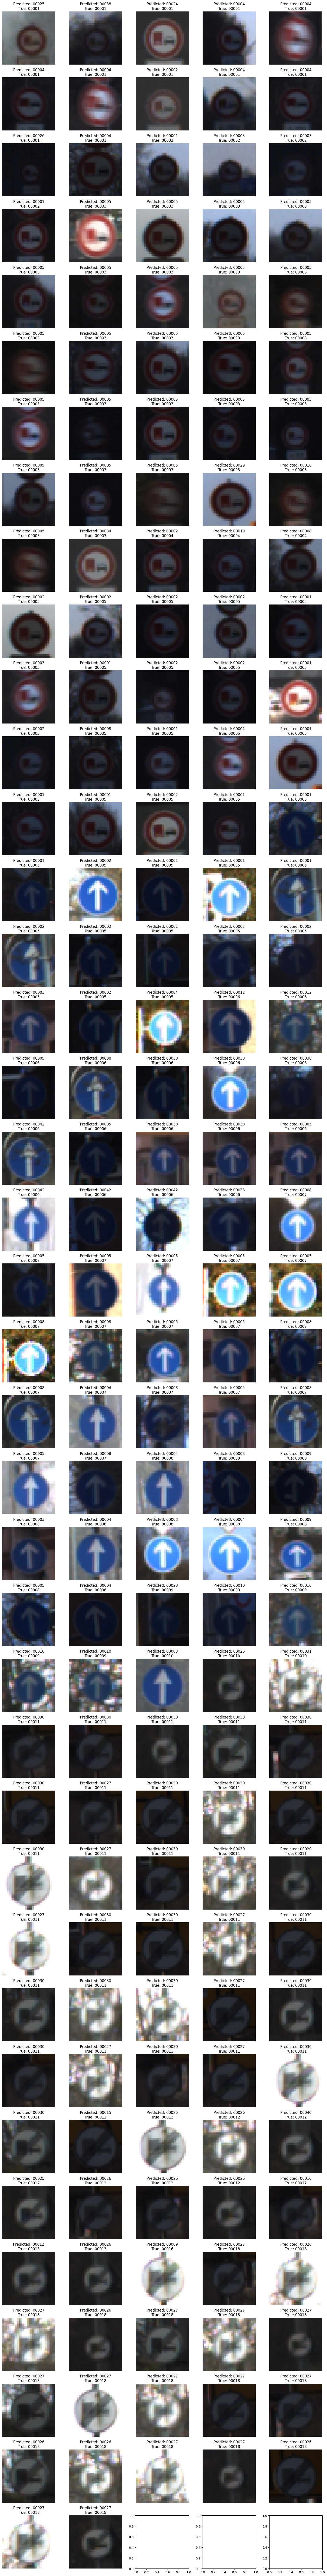

In [ ]:
def print_misclassified_samples(X_test, p_test, y_test, classes):
    misclassified_indices = (p_test != y_test)
    misclassified_images = torch.cat([img.cpu() for img, pred, true_label in zip(X_test, p_test, y_test) if pred != true_label], dim=0)
    misclassified_predictions = p_test[misclassified_indices]
    true_labels = y_test[misclassified_indices]

    num_images = len(misclassified_images)
    num_rows = (num_images // 5) + 1  # 5 images per row
    num_cols = min(num_images, 5)

    # Plot misclassified images
    figure, axis = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    for idx, (image, prediction, true_label) in enumerate(zip(misclassified_images, misclassified_predictions, true_labels)):
        row_idx = idx // 5
        col_idx = idx % 5
        if num_rows > 1:
            axis[row_idx, col_idx].imshow(image.permute(1, 2, 0))
            axis[row_idx, col_idx].set_title(f'Predicted: {classes[int(prediction)]}\nTrue: {classes[int(true_label)]}')
            axis[row_idx, col_idx].axis('off')
        else:
            axis[col_idx].imshow(image.permute(1, 2, 0))
            axis[col_idx].set_title(f'Predicted: {classes[int(prediction)]}\nTrue: {classes[int(true_labels[idx])]}')  # Corrected index
            axis[col_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you have a list of class names corresponding to class indices
class_names = test_dataset.classes
print_misclassified_samples(X_test, p_test, y_test, class_names)


In [ ]:
def train(model, train_loader, test_loader, epochs, loss_fn, optimizer):

    history = {}
    history['accuracy'] = []
    history['test_acc'] = []
    history['loss'] = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time()
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):

            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)

            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        t_correct = 0
        with torch.no_grad():
            for i,t in test_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)

                t_correct += (p == t).sum()

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        t_accuracy = 100 * t_correct / len(test_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.4f}; Accuracy: {accuracy:0.4f}; Test_Acc: {t_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['test_acc'].append(t_accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())

    print('Finished Training')

    return(history)

In [ ]:
epochs = 10
history = train(model, train_loader, test_loader, epochs, criterion, optimizer)

Epoch: 000; Loss: 0.0004; Accuracy: 99.2030; Test_Acc: 97.3793; Elapsed time: 32.2156
Epoch: 001; Loss: 0.0005; Accuracy: 98.9384; Test_Acc: 97.2605; Elapsed time: 32.5156
Epoch: 002; Loss: 0.0005; Accuracy: 99.0181; Test_Acc: 97.1338; Elapsed time: 34.1534
Epoch: 003; Loss: 0.0004; Accuracy: 99.2381; Test_Acc: 97.3317; Elapsed time: 33.2710
Epoch: 004; Loss: 0.0006; Accuracy: 99.0021; Test_Acc: 97.1021; Elapsed time: 33.4389
Epoch: 005; Loss: 0.0005; Accuracy: 99.2922; Test_Acc: 97.1417; Elapsed time: 33.8803
Epoch: 006; Loss: 0.0004; Accuracy: 99.3656; Test_Acc: 96.6350; Elapsed time: 34.0061
Epoch: 007; Loss: 0.0004; Accuracy: 99.3369; Test_Acc: 97.2684; Elapsed time: 32.7682
Epoch: 008; Loss: 0.0002; Accuracy: 99.5824; Test_Acc: 97.5614; Elapsed time: 34.1677
Epoch: 009; Loss: 0.0003; Accuracy: 99.4963; Test_Acc: 97.2842; Elapsed time: 45.0226
Finished Training


In [ ]:
torch.save({
        'model':model.state_dict(),
        'optimizer': optimizer.state_dict()
        },
        os.path.join(MODEL_PATH, 'model.pt'))

best_train = np.asarray(history['accuracy']).argmax()
best_test = np.asarray(history['test_acc']).argmax()

print('Best epoch for train accuracy: :', best_train,' Best epoch for test accuracy: :',  best_test)
print('Test accuracy at epoch ',best_train, ' :', history['test_acc'][best_train], 'Test accuracy at epoch ',best_test, ' :', history['test_acc'][best_test])

Best epoch for train accuracy: : 8  Best epoch for test accuracy: : 8
Test accuracy at epoch  8  : 97.56136 Test accuracy at epoch  8  : 97.56136


In [ ]:
# Code from classes
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix




def show_history_plus(history, fields):

    # summarize history for accuracy
    for hist in fields:

        plt.plot(history[hist])

        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
    plt.legend(list(history.keys()), loc='lower right')
    plt.show()



def show_history(history):

    for key in history.keys():

        # summarize history for accuracy
        plt.plot(history[key])
        plt.title(key)
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.show()


def show_histories(histories, model_names, field='accuracy'):

    # summarize history for accuracy
    for hist in histories:
        plt.plot(hist[field])

    plt.ylabel(field)
    plt.xlabel('epoch')
    plt.legend(model_names, loc='lower right')
    plt.show()


def show_accuracies(train_acc, eval_acc, model_names):
    fig, ax = plt.subplots()
    X = np.arange(len(model_names))

    minT = min(train_acc)
    minE = min(eval_acc)
    min_val = min([minT, minE])

    plt.bar(X, eval_acc, width = 0.4, color = 'b', label='eval')
    plt.bar(X + 0.4, train_acc, color = 'r', width = 0.4, label = "train")
    plt.xticks(X + 0.4 / 2, model_names)
    plt.ylim(top = 100, bottom = min_val - 2)
    plt.legend(loc='lower right')
    plt.show()


def show_histogram(data, classes):

    target_np = [x.numpy().item() for x in data]
    res = Counter(target_np)
    print(res)

    values = [res[x] for x in range(len(classes))]
    indexes = np.arange(len(classes))


    plt.bar(indexes, values, 1)
    plt.xticks(indexes , classes, rotation=45, ha='right')
    plt.show()


def show_confusion_matrix(ground_truth, preds, num_classes):

    cf_matrix = confusion_matrix(ground_truth, preds)


    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], range(num_classes), range(num_classes))
    plt.figure(figsize=(12,6))

    sn.heatmap(df_cm, annot=True, annot_kws={"size": 10} , fmt='.3f') # font size

    plt.show()


def show_loaded_images(rows, cols, data,classes):

    width= 2 * rows
    height= 2 * cols

    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()

    for a in range(rows*cols):
        img, label = data[a]
        subplot_title=(classes[label])
        axes.ravel()[a].set_title(subplot_title)
        axes.ravel()[a].imshow(np.transpose(img.numpy(), (1,2,0)), cmap=plt.cm.gray)
        axes.ravel()[a].axis('off')
    fig.tight_layout()
    plt.show()


def show_transformed_images(rows, cols, data, classes):

    width= 2 * rows
    height= 2 * cols

    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()

    for a in range(rows*cols):
        img, target = data[a]
        subplot_title=(classes[target])
        axes.ravel()[a].set_title(subplot_title)
        axes.ravel()[a].imshow(np.transpose(img.numpy(),(1,2,0)), cmap=plt.cm.gray)
        axes.ravel()[a].axis('off')
    fig.tight_layout()
    plt.show()

def show_predicted_images(rows, cols, data, classes):

    width= 2 * rows
    height= 2 * cols

    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()

    for a in range(rows*cols):
        img = data[a]
        axes.ravel()[a].imshow(np.transpose(img.numpy(),(1,2,0)), cmap=plt.cm.gray)
        axes.ravel()[a].axis('off')
    fig.tight_layout()
    plt.show()

def show_images(rows, cols, images, targets, classes):

    width= 2 * rows
    height= 2 * cols

    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()

    for a in range(rows*cols):
        img, target = images[a], targets[a]
        subplot_title=(classes[target])
        axes.ravel()[a].set_title(subplot_title)
        axes.ravel()[a].imshow(np.transpose(img.numpy(),(1,2,0)), cmap=plt.cm.gray)
        axes.ravel()[a].axis('off')
    fig.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img, classes):

    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img_np = np.transpose(img.numpy(), (1,2,0))
    plt.imshow(img_np, cmap=plt.cm.gray)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(classes[predicted_label],
                                  100*np.max(predictions_array),
                                  classes[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label, num_classes):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(num_classes))
    plt.yticks([])
    thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

def plot_predictions(images, predictions, ground_truth, classes, num_rows= 5, num_cols=3 ):

    num_images = min(num_rows*num_cols, len(predictions))
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], ground_truth, images, classes)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth, len(classes))
    plt.tight_layout()
    plt.show()

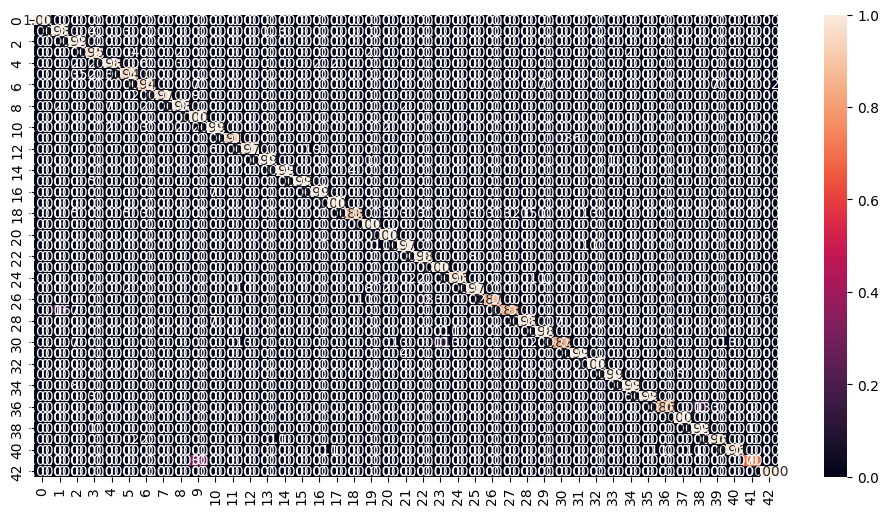

In [ ]:
preds = []
ground_truth = []

for images, targets in test_loader:
    logits = model(images.to(device))
    preds_sparse = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_sparse)
    ground_truth.extend(targets.numpy())

# Access class_to_idx from the original dataset instead of the subset
show_confusion_matrix(ground_truth, preds, len(train_dataset.class_to_idx))


In [ ]:
def plot_wrong_predictions(images, predictions, ground_truth, classes, correct_predictions, num_rows=5, num_cols=3):

    num_images = min(num_rows * num_cols, len(predictions))
    plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
    count = 0
    for i in range(len(predictions)):
        if not correct_predictions[i]:  # Plot only wrongly predicted images
            plt.subplot(num_rows, 2 * num_cols, 2 * count + 1)
            plot_image(i, predictions[i], ground_truth, images, classes)
            plt.subplot(num_rows, 2 * num_cols, 2 * count + 2)
            plot_value_array(i, predictions[i], ground_truth, len(classes))
            count += 1
            if count >= num_images:
                break

    # Add condition to handle empty plots
    if count == 0:
        plt.text(0.5, 0.5, 'No wrongly predicted images', horizontalalignment='center', verticalalignment='center',
                 fontsize=12, color='gray', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()


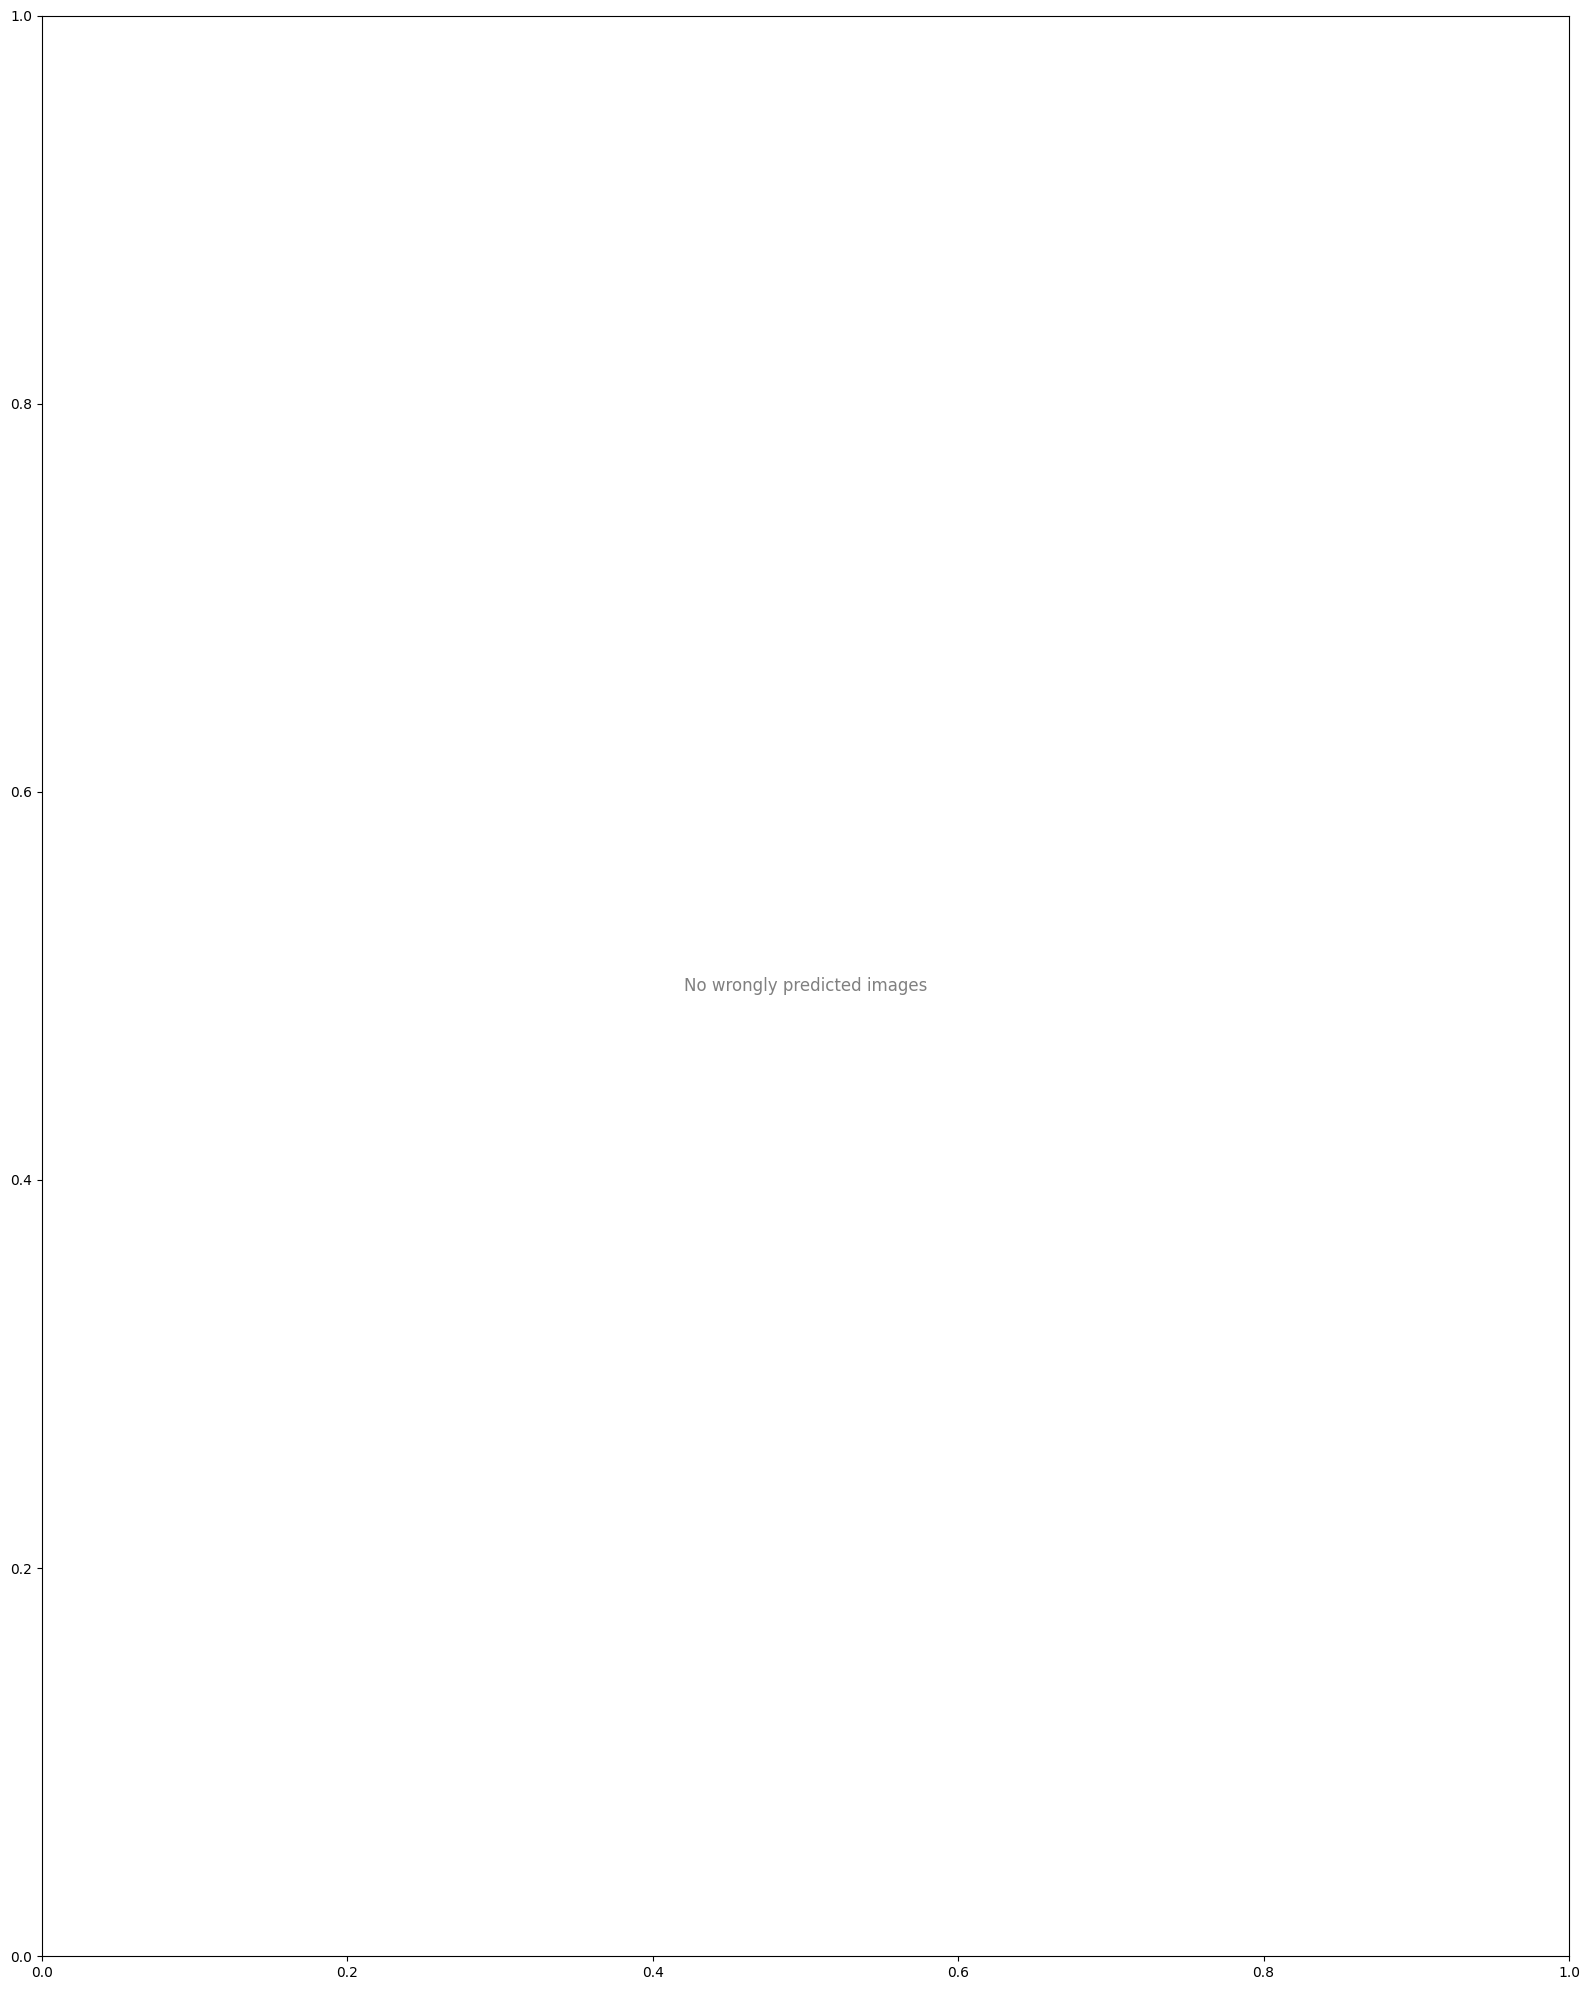

In [ ]:
images, targets = next(iter(test_loader))
logits = model(images.to(device))
predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()

# Determine correct predictions
_, predicted_labels = torch.max(logits, 1)
targets = targets.to(device)  # Move targets to the same device as predicted_labels
correct_predictions = predicted_labels == targets

plot_wrong_predictions(images, predictions, targets, train_dataset.classes, correct_predictions, 10, 4)
